In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from intercluster import *
from intercluster.decision_trees import *
from intercluster.decision_sets import *
from intercluster.mining import *
from intercluster.pruning import *
from intercluster.experiments import *
%load_ext autoreload
%autoreload 2

In [3]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 170
np.random.seed(seed)

In [4]:
palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

cluster_color_dict = {i: cmap(7 - i) for i in range(8)}
cluster_color_dict[-1] = 'grey'

color_dict = {'pond' : cmap(5), 'lake': cmap(1), 'wetland': cmap(7), 'other' : cmap(6)}

# This assumes tex is installed in your system, 
# if not, you may simply remove most of this, aside from font.size 
# (doing so, however, will break certain plotting functions)
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

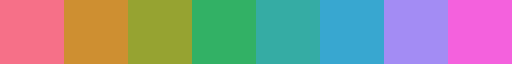

In [5]:
cmap

### Load data

In [629]:
pond_df = pd.read_csv('../data/pond_lake/pond_data.csv', encoding_errors='ignore')

classification_dict = {
    'pond' : 'pond',
    'lake' : 'lake',
    'small water bodies or ponds' : 'pond',
    'pond or small lake' : 'pond',
    'wetland vs. lake' : None,
    'lakes' : 'lake',
    'shallow lake' : 'lake',
    'urban ponds' : 'pond',
    'shallow lakes' : 'lake',
    'karst pond' : 'pond',
    'small lake' : 'lake',
    'pothole' : 'other',
    'pools and ponds; bodri (italian term)' : 'pond',
    'temporary pond' : 'pond',
    'stormwater pond' : 'pond',
    'karst ponds' : 'pond',
    'subtropical shallow lake' : 'lake',
    'small lakes' : 'lake',
    'treatment cells in constructed wetlands' : 'wetland',
    'kettle hole' : 'other',
    'pond or reservoir' : 'pond',
    'lentic small water bodies' : 'pond',
    'pool' : 'other',
    'zbiornik(pond)' : 'pond',
    'permenant pond' : 'pond',
    'rock pools' : 'other',
    'dune ponds' : 'pond',
    'farm pond; small impoundment' : 'pond',
    'farm pond' : 'pond',
    'mediterranean wetland' : 'wetland',
    'small humic lakes' : 'lake',
    'high planktivory lake' : 'lake',
    'inland-lake' : 'lake',
    'pond/tundra pond' : 'pond',
    'lakes and reservoirs (broken into small and large)' : 'lake',
    'wetland' : 'wetland',
    'small (< 10 km2) seasonally ice-covered arctic lakes' : 'lake',
    'wetland; pond' : None,
    'peat lake' : 'lake',
    'small tropical lake' : 'lake',
    'meteorite crater ponds' : 'pond',
    'agricultural water reservoir' : 'pond',
    'coastal plain shallow lake' : 'lake',
    'residential pond' : 'pond',
    'small impoundment' : 'other',
    'small-sized lentic ecosystem; lake' : None,
    'reservoir' : 'other',
    'small acidic bog lake' : 'lake',
    'in-field pond' : 'pond',
    'temporary lake' : 'lake',
    'lake (reservoir)' : 'lake',
    'shallow subtropical lake' : 'lake',
    'wetland/lake' : None,
    'vernal pool' : 'other',
    'temporary lake/seasonal pond' : None,
    'permanent lake' : 'lake',
    'other' : 'other',
    'ponds' : 'pond',
    'deep refuge lake' : 'lake',
    'lake/pond' : None,
    'lagoon; shallow lake' : 'lake',
    'marsh' : 'wetland',
    'terporary wetland; also temparary pond' : None,
    'aquatic environment' : 'other',
    'near-natural ponds' : 'pond',
    'small-sized lentic ecosystem; wetland' : None,
}

pond_df['ecosystem'] = pond_df['author_term'].map(classification_dict)
pond_df = pond_df[pond_df['ecosystem'].notna()]
pond_df = pond_df[pond_df['ecosystem'].isin(['pond', 'lake'])]

In [665]:
select_features = [
    'mean_surfacearea_m2',
    'max_depth_m',
    'macrophytes_percentcover',
    'tn_ugpl',
    'tp_ugpl',
    'chla_ugpl',
    'ph',
    'ecosystem'
]
sub_pond_df = pond_df.loc[:, select_features]
sub_pond_df.columns = ['surface_area', 'depth', 'veg_cover', 'TN', 'TP', 'chl_a', 'pH', 'ecosystem']
#sub_pond_df['ecosystem'] = 'pond'

# Convert m2 to ha
sub_pond_df['surface_area'] = sub_pond_df['surface_area'] / 10000

# convert veg cover from percentage to proportion
sub_pond_df['veg_cover'] = sub_pond_df['veg_cover'] / 100

#sub_pond_df = sub_pond_df.loc[:,['surface_area', 'depth', 'veg_cover', 'ecosystem']]
#sub_pond_df = sub_pond_df.loc[:,['veg_cover', 'TN', 'TP', 'chl_a', 'pH', 'ecosystem']]

# remove rows with more than 2 missing features
#sub_pond_df = sub_pond_df.dropna(thresh=sub_pond_df.shape[1]-1)

sub_pond_df



,surface_area,depth,veg_cover,TN,TP,chl_a,pH,ecosystem
0,NaN,1.0,NaN,NaN,1383.3,28.827,6.730,pond
1,NaN,1.0,NaN,NaN,1223.3,15.640,6.950,pond
2,NaN,0.3,NaN,NaN,695.0,8.150,6.755,pond
3,NaN,0.7,NaN,NaN,1130.0,29.940,6.555,pond
5,3.700,NaN,NaN,NaN,24.5,7.700,NaN,lake
...,...,...,...,...,...,...,...,...
1322,4.600,NaN,NaN,NaN,NaN,NaN,NaN,lake
1323,0.030,NaN,NaN,276.2,11.3,8.200,5.400,lake
1324,1.500,5.6,NaN,NaN,NaN,8.000,4.700,lake
1325,0.336,4.5,NaN,1700.0,27.0,32.300,6.500,lake


In [666]:
lake_df = pd.read_csv('../data/pond_lake/nla12_keyvariables_data.csv')
lake_physical = pd.read_csv('../data/pond_lake/nla2012_wide_phabmet_10202016.csv')
lake_chemical = pd.read_csv('../data/pond_lake/nla2012_waterchem_wide.csv')

veg_covers = []
for idt in lake_df.UID:
    res = lake_physical.loc[lake_physical.UID == idt, 'AMFCALL'].values
    #res = lake_physical.loc[lake_physical.UID == idt, 'AMFCEMERGENT'].values
    if len(res) == 1:
        veg_covers.append(res[0])
    else:
        veg_covers.append(np.nan)
lake_df['veg_cover'] = veg_covers

phs = []
for idt in lake_df.UID:
    res = lake_chemical.loc[lake_chemical.UID == idt, 'PH_RESULT'].values
    if len(res) == 1:
        phs.append(res[0])
    else:
        phs.append(np.nan)
lake_df['pH'] = phs

select_features = ['AREA_HA', 'INDEX_SITE_DEPTH', 'veg_cover', 'NTL_RESULT', 'PTL_RESULT', 'CHLX_RESULT', 'pH']
sub_lake_df = lake_df.loc[:, select_features]
sub_lake_df.columns = ['surface_area', 'depth', 'veg_cover', 'TN', 'TP', 'chl_a', 'pH']
sub_lake_df['ecosystem'] = 'lake'

# Convert from mg/L to ug/L
sub_lake_df['TN'] = sub_lake_df['TN'] * 1000

#sub_lake_df = sub_lake_df.loc[:,['surface_area', 'depth', 'veg_cover', 'ecosystem']]
#sub_lake_df = sub_lake_df.loc[:,['veg_cover', 'TN', 'TP', 'chl_a', 'pH', 'ecosystem']]

# remove rows with more than 2 missing features
#sub_lake_df = sub_lake_df.dropna(thresh=sub_lake_df.shape[1]-0)

sub_lake_df

,surface_area,depth,veg_cover,TN,TP,chl_a,pH,ecosystem
0,1301.871970,13.1,NaN,505.0,30.0,18.000000,8.54,lake
1,1301.871970,13.7,0.155000,376.0,25.0,17.520000,8.28,lake
2,72.950420,17.3,0.215000,389.0,12.0,10.000000,7.37,lake
3,10363.258480,6.5,NaN,449.0,56.0,32.000000,8.34,lake
4,4731.474336,19.8,0.025000,344.0,37.0,8.945455,7.99,lake
...,...,...,...,...,...,...,...,...
1133,32.047821,15.8,NaN,59.0,14.0,1.032000,7.01,lake
1134,1.758773,2.5,0.502500,480.0,64.0,3.272000,8.77,lake
1135,14.420022,5.5,0.358333,318.0,33.0,0.829333,8.27,lake
1136,2762.171646,18.5,0.120000,355.0,36.0,5.493333,8.81,lake


In [671]:
wetland_df = pd.read_csv('../data/pond_lake/nwca2011_aachar.csv')
wetland_vegetation = pd.read_csv('../data/pond_lake/nwca2011_vegmetrics.csv')
wetland_chemical = pd.read_csv('../data/pond_lake/nwca2011_waterchem.csv')
wetland_chl = pd.read_csv('../data/pond_lake/nwca2011_chla.csv')

depths = []
veg_covers = []
tns = []
tps = []
chls = []
phs = []
for uid in wetland_df.UID:
    res = wetland_vegetation.loc[wetland_vegetation.UID == uid, 'MAX_H2O_DEPTH'].values
    if len(res) == 1:
        depths.append(res[0])
    else:
        depths.append(np.nan)
    
    #res = wetland_vegetation.loc[wetland_vegetation.UID == uid, 'XCOV_H2O_EMERGVEG'].values
    res = wetland_vegetation.loc[wetland_vegetation.UID == uid, 'XCOV_H2O_NOVEG'].values
    if len(res) == 1:
        #veg_covers.append(res[0])
        veg_covers.append(100 - res[0])
    else:
        veg_covers.append(np.nan)
    
    res = wetland_chemical.loc[wetland_chemical.UID == uid, 'TN'].values
    if len(res) == 1:
        tns.append(res[0])
    else:
        tns.append(np.nan)
    
    res = wetland_chemical.loc[wetland_chemical.UID == uid, 'TP'].values
    if len(res) == 1:
        tps.append(res[0])
    else:
        tps.append(np.nan)
    
    res = wetland_chl.loc[wetland_chl.UID == uid, 'CHLA'].values
    if len(res) == 1:
        chls.append(res[0])
    else:
        chls.append(np.nan)
    
    res = wetland_chemical.loc[wetland_chemical.UID == uid, 'PH'].values
    if len(res) == 1:
        phs.append(res[0])
    else:
        phs.append(np.nan)

wetland_df['surface_area'] = np.nan
wetland_df['depth'] = depths
wetland_df['veg_cover'] = veg_covers
wetland_df['TN'] = tns
wetland_df['TP'] = tps
wetland_df['chl_a'] = chls
wetland_df['pH'] = phs

select_features = ['surface_area', 'depth', 'veg_cover', 'TN', 'TP', 'chl_a', 'pH']
sub_wetland_df = wetland_df.loc[:, select_features]
#sub_wetland_df.columns = ['surface_area', 'depth', 'veg_cover', 'TN', 'TP', 'chl_a', 'pH']
sub_wetland_df['ecosystem'] = 'wetland'

# Convert from cm to m
# NOTE: I'm just guessing this was originally in cm, since depths are very large otherwise
sub_wetland_df['depth'] = sub_wetland_df['depth'] / 100

# Convert from percent to proportion
sub_wetland_df['veg_cover'] = sub_wetland_df['veg_cover'] / 100

# Convert from mg/L to ug/L
sub_wetland_df['TN'] = sub_wetland_df['TN'] * 1000

#sub_wetland_df = sub_wetland_df.loc[:,['surface_area', 'depth', 'veg_cover', 'ecosystem']]
#sub_wetland_df = sub_wetland_df.loc[:,['veg_cover', 'TN', 'TP', 'chl_a', 'pH', 'ecosystem']]

#sub_wetland_df = sub_wetland_df.dropna(thresh=sub_wetland_df.shape[1]-0)

In [672]:
sub_wetland_df

,surface_area,depth,veg_cover,TN,TP,chl_a,pH,ecosystem
0,NaN,0.00,1.000,NaN,NaN,NaN,NaN,wetland
1,NaN,0.02,0.776,NaN,NaN,NaN,NaN,wetland
2,NaN,0.00,1.000,NaN,NaN,NaN,NaN,wetland
3,NaN,0.00,1.000,NaN,NaN,NaN,NaN,wetland
4,NaN,0.00,1.000,1223.0,29.0,6.44,8.14,wetland
...,...,...,...,...,...,...,...,...
1229,NaN,0.00,1.000,NaN,NaN,NaN,NaN,wetland
1230,NaN,0.00,1.000,NaN,NaN,NaN,NaN,wetland
1231,NaN,0.00,1.000,NaN,NaN,NaN,NaN,wetland
1232,NaN,0.00,1.000,NaN,NaN,NaN,NaN,wetland


In [679]:
# Combine data and log-transform features with long-tailed distributions
df = pd.concat([sub_pond_df, sub_lake_df, sub_wetland_df], ignore_index=True)
df.surface_area = np.log(df.surface_area + 1)
df.depth = np.log(df.depth + 1)
df.TN = np.log(df.TN + 1)
df.TP = np.log(df.TP + 1)
df.chl_a = np.log(df.chl_a + 1)

In [680]:
df

,surface_area,depth,veg_cover,TN,TP,chl_a,pH,ecosystem
0,NaN,0.693147,NaN,NaN,7.232950,3.395414,6.730,pond
1,NaN,0.693147,NaN,NaN,7.110125,2.811809,6.950,pond
2,NaN,0.262364,NaN,NaN,6.545350,2.213754,6.755,pond
3,NaN,0.530628,NaN,NaN,7.030857,3.432050,6.555,pond
4,1.547563,NaN,NaN,NaN,3.238678,2.163323,NaN,lake
...,...,...,...,...,...,...,...,...
3539,NaN,0.000000,1.0,NaN,NaN,NaN,NaN,wetland
3540,NaN,0.000000,1.0,NaN,NaN,NaN,NaN,wetland
3541,NaN,0.000000,1.0,NaN,NaN,NaN,NaN,wetland
3542,NaN,0.000000,1.0,NaN,NaN,NaN,NaN,wetland


### Visualization

In [786]:
# Select data subset
select_features = ['veg_cover','depth', 'TN', 'TP', 'chl_a', 'pH', 'ecosystem']
select_ecosystems = ['pond', 'wetland']
sub_df = df.loc[:, select_features]
sub_df = sub_df[sub_df['ecosystem'].isin(select_ecosystems)]

# Remove entries with more than 1 missing features
sub_df = sub_df.dropna(thresh=sub_df.shape[1]-1)

# Standard scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(sub_df.iloc[:, :-1])
scaled_df = pd.DataFrame(scaled_features, columns=sub_df.columns[:-1])
scaled_df['ecosystem'] = sub_df['ecosystem'].values

# Impute missing values
imputer = KNNImputer(n_neighbors=5)
imputed_features = imputer.fit_transform(scaled_df.iloc[:, :-1])
imputed_df = pd.DataFrame(imputed_features, columns=scaled_df.columns[:-1])
imputed_df['ecosystem'] = scaled_df['ecosystem'].values

sub_df = imputed_df

In [787]:
sub_df.ecosystem.value_counts()

ecosystem
wetland    681
pond        47
Name: count, dtype: int64

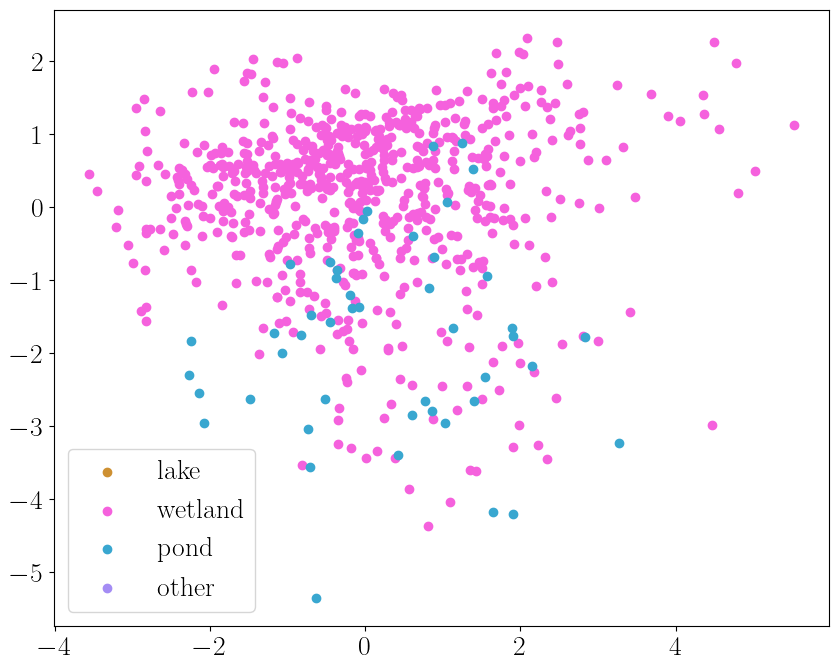

In [788]:
pca = PCA(n_components=2)
data_dim = pca.fit_transform(sub_df.iloc[:, :-1])

fig, ax = plt.subplots(figsize=(10, 8))
for ecotype in ['lake', 'wetland','pond', 'other']:
    idx = sub_df['ecosystem'] == ecotype
    ax.scatter(data_dim[idx,0], data_dim[idx,1], label=ecotype, color=color_dict[ecotype])

plt.legend()

KeyError: 'veg_cover'

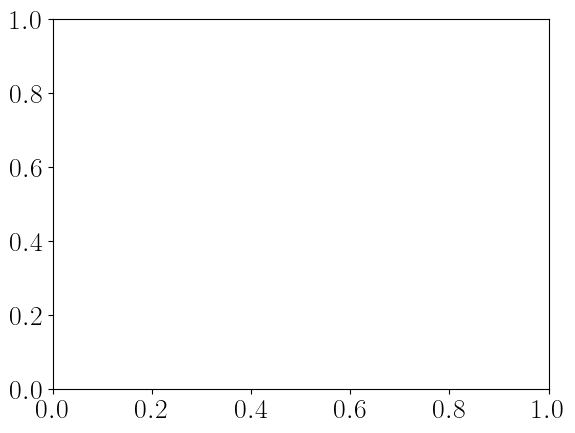

In [742]:
sub_df.plot.scatter(x='veg_cover', y='chl_a', c=sub_df['ecosystem'].map(color_dict))

### Classification

In [789]:
# Data and labels
X = sub_df.iloc[:, :-1].values
label_dict = {'pond': 0, 'lake': 1, 'wetland': 2, 'other': 3}
rev_label_dict = {v: k for k, v in label_dict.items()}
y_true_ = np.array([label_dict[lab] for lab in sub_df['ecosystem'].values])
y_true = labels_format(y_true_)

In [797]:
dt = DecisionTree(max_leaf_nodes = 4)
dt.fit(X, y_true)
y_pred = dt.predict(X)
y_pred_ = flatten_labels(y_pred)

In [798]:
N = y_true_.shape[0]
accuracy = (y_true_ == y_pred_).sum() / N
accuracy

0.9546703296703297

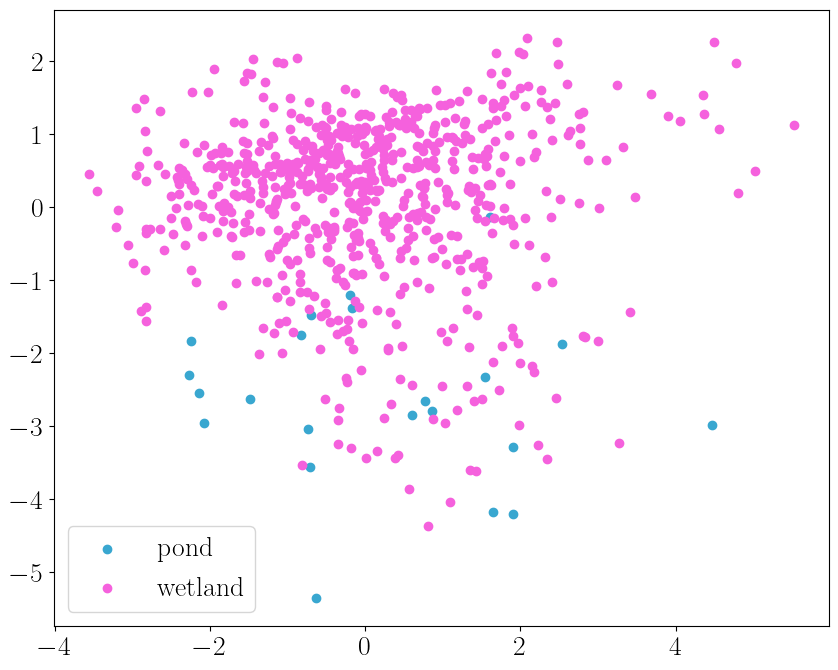

In [799]:
fig, ax = plt.subplots(figsize=(10, 8))
for clabel in np.unique(y_pred_):
    idx = y_pred_ == clabel
    ecotype = rev_label_dict[clabel]
    ax.scatter(data_dim[idx,0], data_dim[idx,1], label=ecotype, color=color_dict[ecotype])

plt.legend()

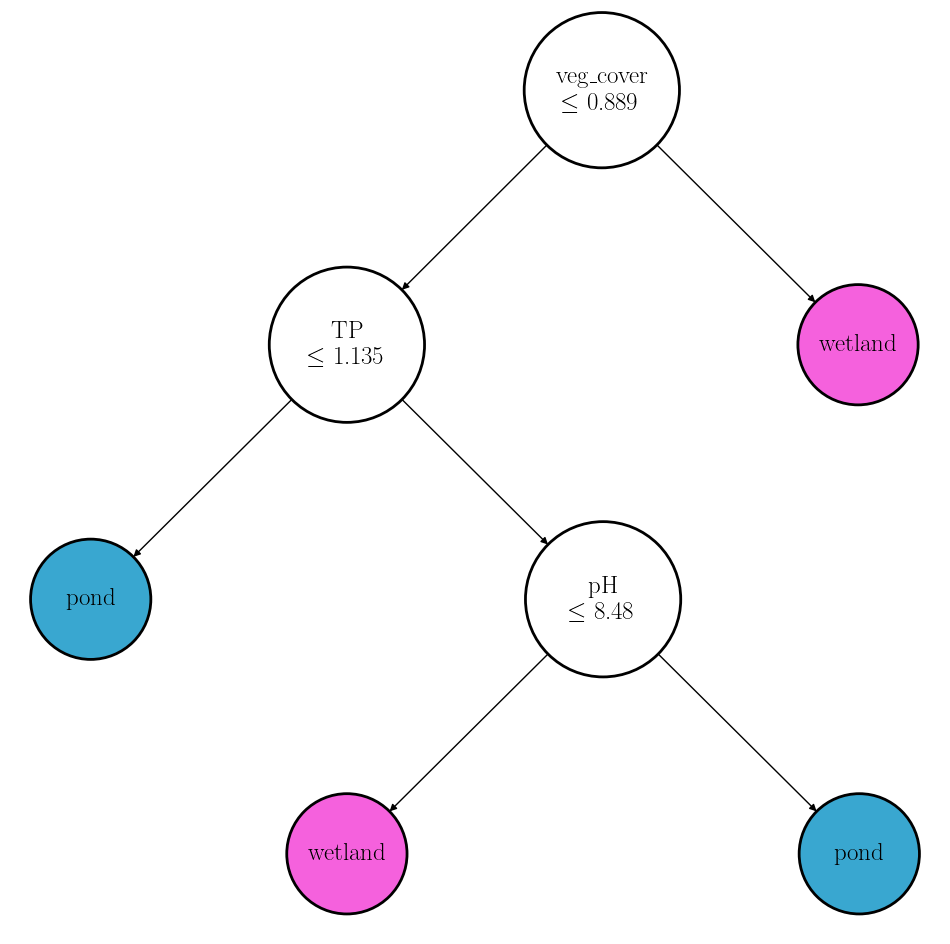

In [800]:
tree_color_dict = {i: color_dict[rev_label_dict[i]] for i in range(len(rev_label_dict))}
tree_labels = [rev_label_dict[i] for i in range(len(rev_label_dict))]
feature_labels = [r'area $\log$(ha)', r'depth $\log$(m)', 'veg_cover', r'TN $\log$(ug/L)',
                   r'TP $\log$(ug/L)', r'chl_a $\log$(ug/L)', 'pH']
feature_labels = feature_labels[3:]
feature_labels = sub_df.columns[:-1].tolist()
draw_tree(
    dt.root,
    feature_labels = feature_labels,
    leaf_labels = tree_labels,
    color_dict = tree_color_dict,
    data_scaler = scaler
)

### Clustering

In [606]:
# KMeans clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=seed)
kmeans.fit(X)
y_kmeans_ = kmeans.labels_
y_kmeans = labels_format(y_kmeans_)

/var/folders/gx/n_zylxjn46v7vssq3_z29kpr0000gn/T/ipykernel_25029/1880975785.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


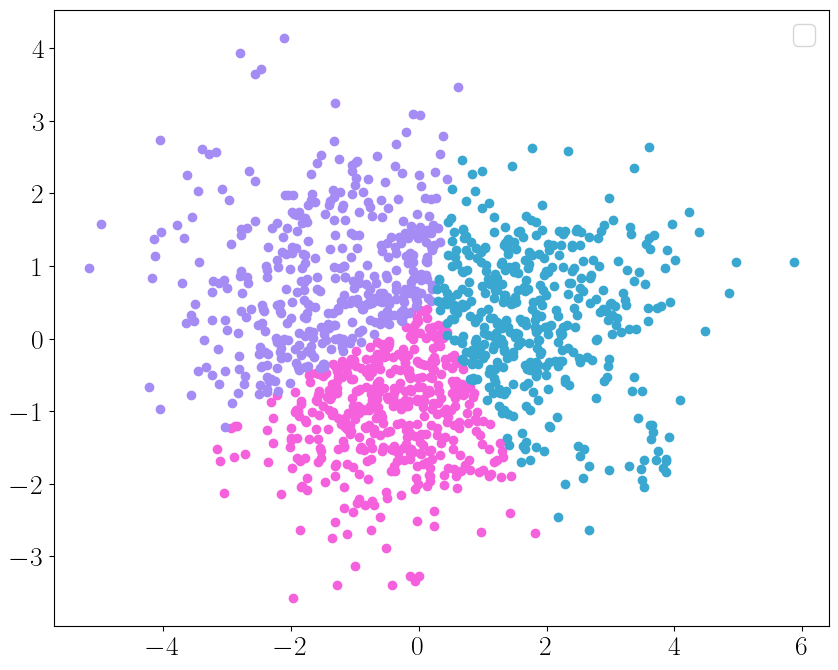

In [607]:
fig, ax = plt.subplots(figsize=(10, 8))
for clabel in np.unique(y_kmeans_):
    idx = y_kmeans_ == clabel
    ax.scatter(data_dim[idx,0], data_dim[idx,1], color=cluster_color_dict[clabel])

plt.legend()

In [608]:
# IMM
exkmc_tree = ExkmcTree(
    k = k,
    kmeans = kmeans,
    max_leaf_nodes = k,
    imm = True
)
exkmc_tree.fit(X)
y_exkmc = exkmc_tree.predict(X, leaf_labels = False)
y_exkmc_ = flatten_labels(y_exkmc)

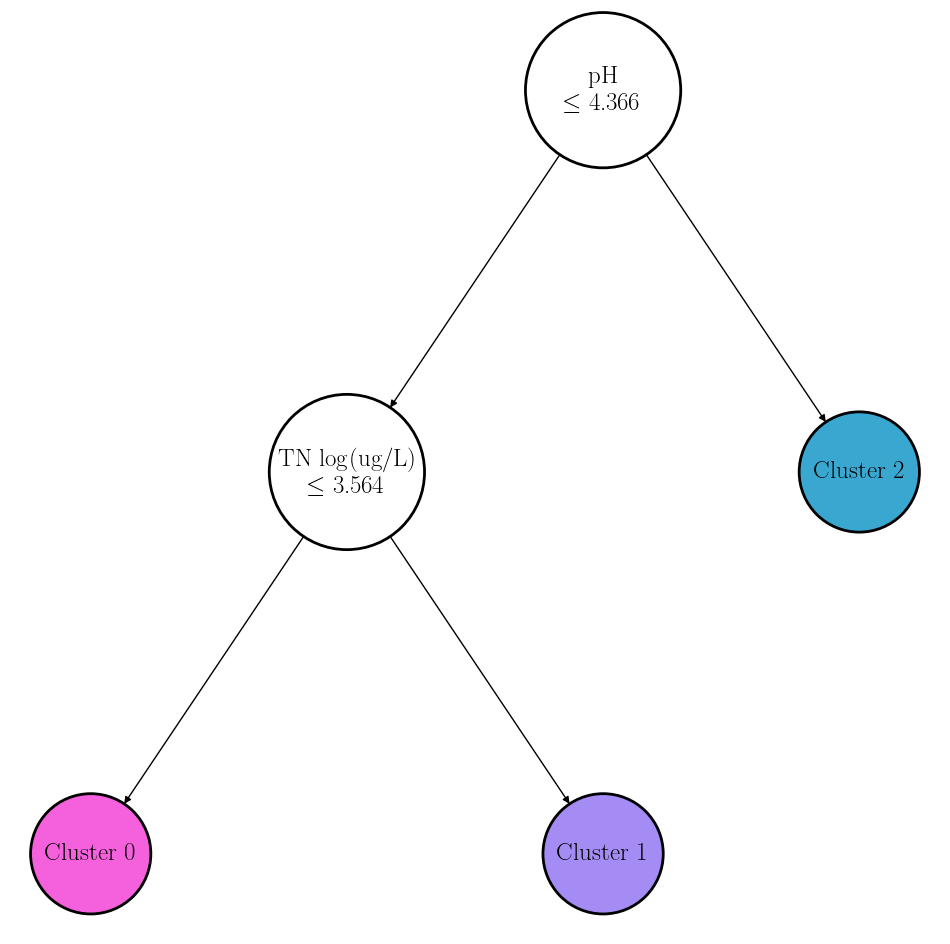

In [609]:
feature_labels = [r'area $\log$(ha)', r'depth $\log$(m)', 'veg_cover', r'TN $\log$(ug/L)',
                   r'TP $\log$(ug/L)', r'chl_a $\log$(ug/L)', 'pH']
feature_labels = feature_labels[3:]
draw_tree(
    exkmc_tree.root,
    feature_labels = feature_labels,
    color_dict = cluster_color_dict,
    data_scaler = scaler
)

Text(0, 0.5, 'TP (scaled)')

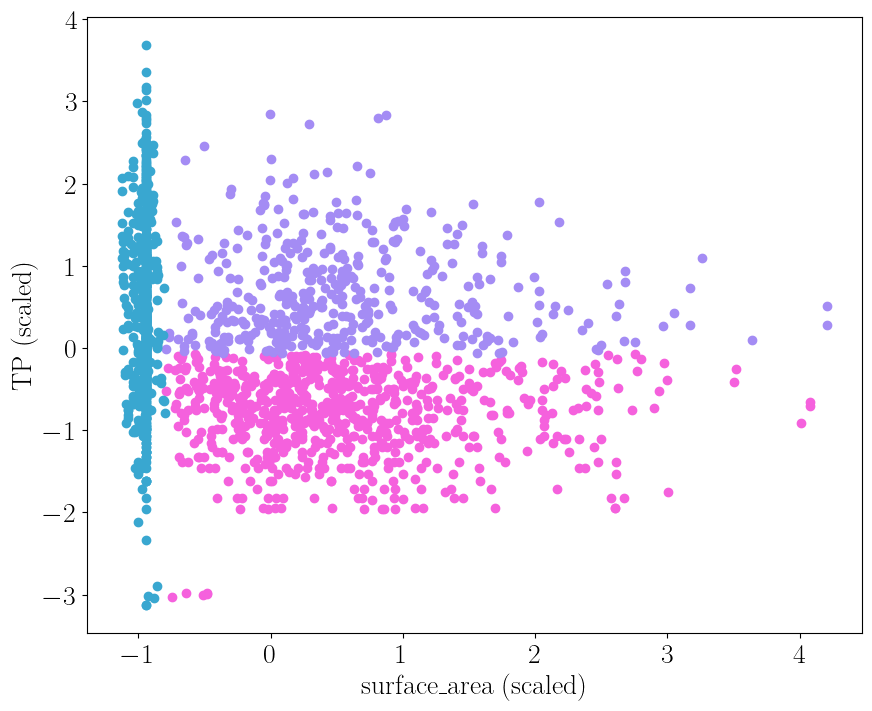

In [410]:
fig, ax = plt.subplots(figsize=(10, 8))
for clabel in np.unique(y_exkmc_):
    idx = y_exkmc_ == clabel
    ax.scatter(X[idx,0], X[idx,4], color=cluster_color_dict[clabel])

ax.set_xlabel('surface_area (scaled)')
ax.set_ylabel('TP (scaled)')

In [610]:
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=25)
y_dbscan_ = dbscan.fit_predict(X)
y_dbscan = labels_format(y_dbscan_)

/var/folders/gx/n_zylxjn46v7vssq3_z29kpr0000gn/T/ipykernel_25029/396728432.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


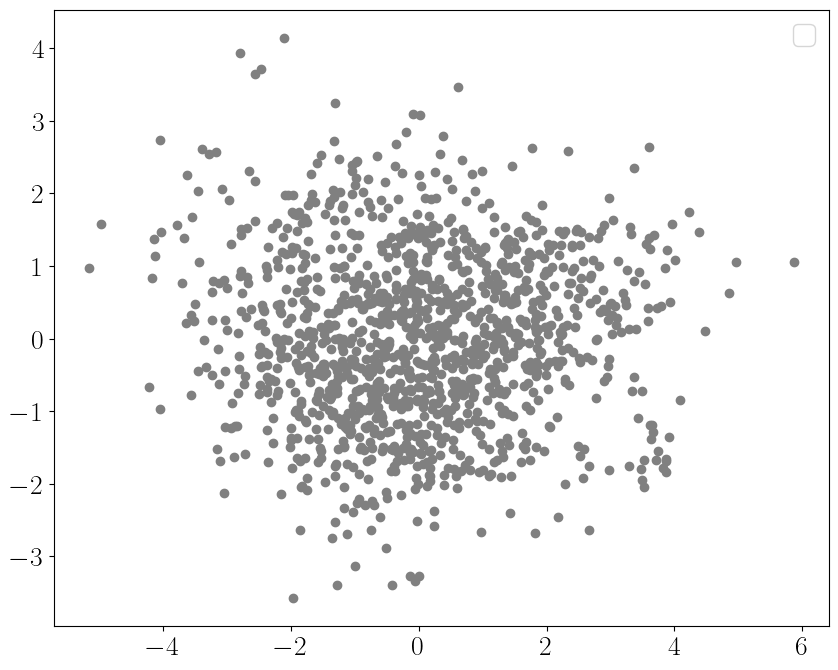

In [611]:
fig, ax = plt.subplots(figsize=(10, 8))
for clabel in np.unique(y_dbscan_):
    idx = y_dbscan_ == clabel
    ax.scatter(data_dim[idx,0], data_dim[idx,1], color=cluster_color_dict[clabel])

plt.legend()

In [450]:
# Decision set clustering
np.random.seed(seed)
lambd = 0.5
point_miner = PointwiseMiner(lambd = lambd, n_features = 3, rules_per_point = 25)
dsclust = DSCluster(lambd = lambd, n_rules = 3, rule_miner = point_miner)
dsclust.fit(X, y_dbscan)
y_dsclust = dsclust.predict(X)
y_dsclust_ = flatten_labels(y_dsclust) 

ValueError: Input feature labels must have as least as many features as the condition's maximum feature index.

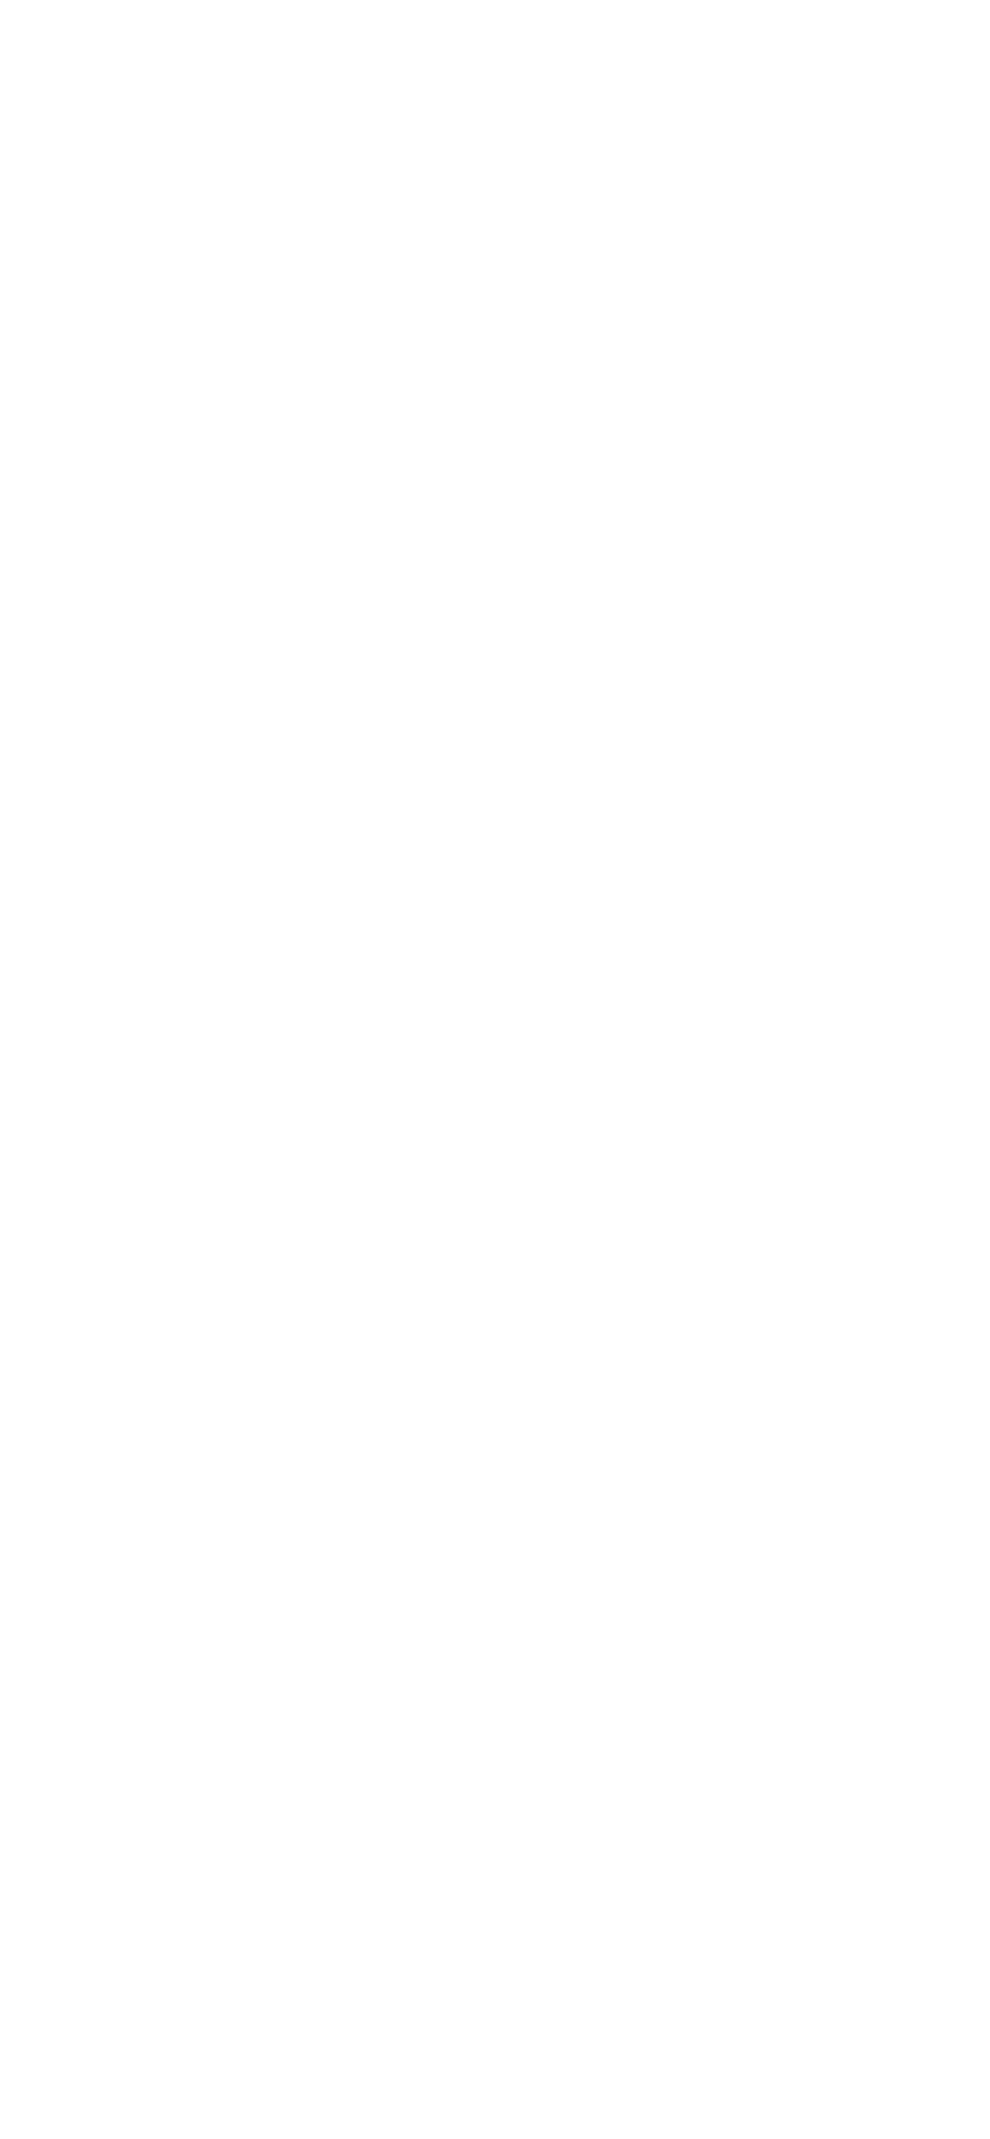

In [ ]:
feature_labels = [r'area $\log$(ha)', r'depth $\log$(m)', 'veg_cover', r'TN $\log$(ug/L)',
                   r'TP $\log$(ug/L)', r'chl_a $\log$(ug/L)', 'pH']
feature_labels = feature_labels[3:]

plot_decision_set(
    dsclust.decision_set,
    dsclust.decision_set_labels,
    feature_labels = feature_labels,
    data_scaler = scaler,
    color_dict = cluster_color_dict
)

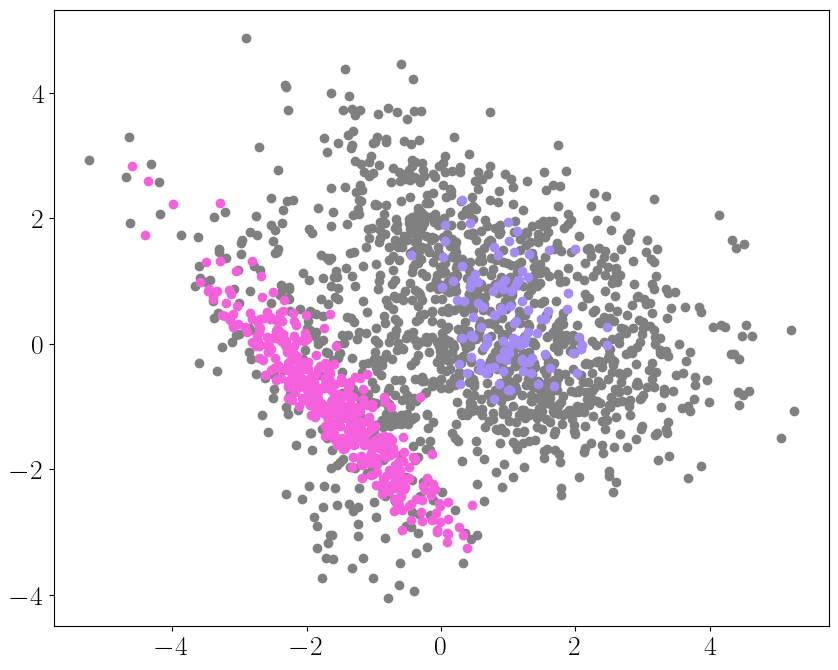

In [408]:
fig, ax = plt.subplots(figsize=(10, 8))
for clabel in np.unique(y_dsclust_):
    idx = y_dsclust_ == clabel
    ax.scatter(data_dim[idx,0], data_dim[idx,1], color=cluster_color_dict[clabel])



In [447]:
X.shape

(1898, 7)

Text(0, 0.5, 'pH (scaled)')

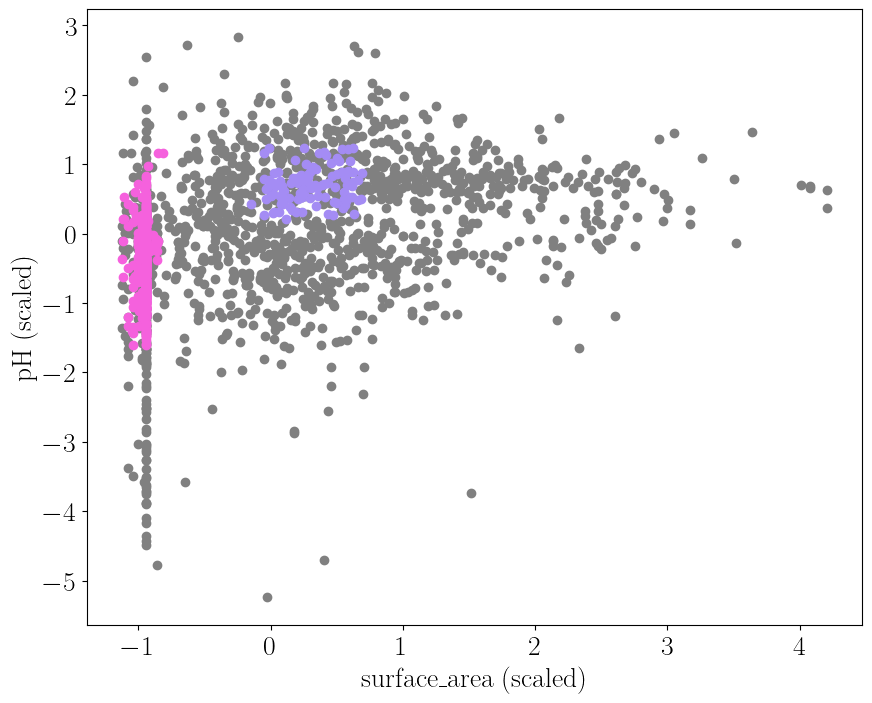

In [448]:
fig, ax = plt.subplots(figsize=(10, 8))
for clabel in np.unique(y_dsclust_):
    idx = y_dsclust_ == clabel
    ax.scatter(X[idx,0], X[idx,6], color=cluster_color_dict[clabel])

ax.set_xlabel('surface_area (scaled)')
ax.set_ylabel('pH (scaled)')

In [445]:
df

,surface_area,depth,veg_cover,TN,TP,CHL,pH,ecosystem
0,0.048033,0.161157,-1.099434,-0.450930,-0.080875,0.487473,-0.311276,pond
1,-1.078396,-0.618738,-0.832914,2.988379,2.090951,0.797710,-0.797212,pond
2,-0.912473,-0.718018,0.366426,2.881563,2.150079,0.683632,-0.628191,pond
3,-0.926532,-0.461171,-0.433134,2.952256,1.995351,0.728797,-0.554244,pond
4,-0.912473,-0.782464,0.233166,2.465763,1.862658,1.089806,-0.406350,pond
...,...,...,...,...,...,...,...,...
1893,-0.941052,-1.296034,1.299246,-0.725995,-0.376256,-1.328846,0.375374,wetland
1894,-0.941052,-1.214372,1.245942,-0.875655,-0.483056,-0.790669,-0.807776,wetland
1895,-0.941052,-0.865802,1.272594,-0.275017,-0.213696,-0.699988,-2.519117,wetland
1896,-0.974225,-0.865802,0.643607,0.914736,1.312673,1.231273,-1.124691,wetland
